In [1]:
import pandas as pd
import pickle
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from haversine import haversine
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import statsmodels.api as sm



df_base = pd.read_csv('../kaggle_data/input/train.csv')
weather = pd.read_csv('../kaggle_data/input/weather.csv')
spray = pd.read_csv('../kaggle_data/input/spray.csv')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Change everything to datetimes:
    
df_base.Date = pd.to_datetime(df_base.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

In [3]:
train, test = train_test_split(df_base, test_size =0.20, random_state=42)

In [4]:


mdf = train.groupby(['Latitude', 'Longitude','Date','Species'])[['NumMosquitos']].sum()

In [20]:
tdf = train.groupby(['Latitude', 'Longitude','Species', 'Address', 'Date'], sort=True,
                 as_index = True)[['NumMosquitos', 'WnvPresent']].sum().reset_index()

tdf.head()

,Latitude,Longitude,Species,Address,Date,NumMosquitos,WnvPresent
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-02,6,0
1,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-07,26,0
2,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-15,15,0
3,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-22,2,0
4,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-24,2,0


In [6]:
import folium
from folium import plugins

In [7]:
tdf[tdf['Species']=='CULEX PIPIENS'].head()


bounds = (tdf.Longitude.min(), tdf.Longitude.max())

In [8]:
bounds

(-87.930995, -87.531635)

In [9]:
Chicago = folium.Map()

locations = tdf[['Latitude','Longitude', 'NumMosquitos']].as_matrix()
Chicago.add_child(plugins.HeatMap(locations, radius=10, min_opacity = 0.5))
# Chicago.add_child(plugins.MarkerCluster(locations))
# Chicago.add_child(plugins.FastMarkerCluster(locations))
Chicago.fit_bounds([[41.644612, -87.930995], [42.01743, -87.531635]])
Chicago

In [10]:
Chicago.get_bounds()
Chicago.zoom_start

1

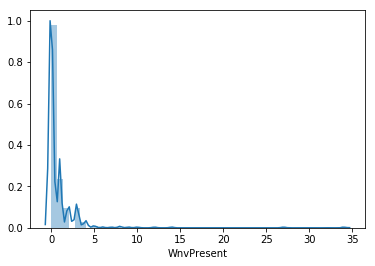

In [11]:
# nonzero = Poisson(tdf['WnvPresent'], tdf[['Latitude', 'Species', 'NumMosquitos']]to

sns.distplot(tdf['WnvPresent'])

In [12]:
tdf['site'] = LabelEncoder().fit_transform(tdf['Address'])
tdf.head()

,Latitude,Longitude,Species,Address,NumMosquitos,WnvPresent,site
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",53,0,120
1,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",64,0,120
2,41.644612,-87.604498,CULEX RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",1,0,120
3,41.659112,-87.538693,CULEX PIPIENS,"4000 East 130th Street, Chicago, IL 60633, USA",293,3,56
4,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,"4000 East 130th Street, Chicago, IL 60633, USA",735,0,56


In [13]:
exo = pd.concat([ tdf['NumMosquitos'],pd.get_dummies(tdf['Species'], drop_first=True),pd.get_dummies(tdf['site'], drop_first=True)], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = tdf['WnvPresent']
glm_gamma = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  520
Model:                            GLM   Df Residuals:                      375
Model Family:                 Poisson   Df Model:                          144
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -308.90
Date:                Tue, 06 Mar 2018   Deviance:                       176.21
Time:                        08:49:58   Pearson chi2:                     154.
No. Iterations:                    25                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
NumMosquitos               0.0002   3.22e-05      5.075      0.000       0.000       0.000
CULEX PIPIENS   

In [14]:
pippi=tdf[tdf['Species'].str.contains('PIPIENS')]
pippi.head()

,Latitude,Longitude,Species,Address,NumMosquitos,WnvPresent,site
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",53,0,120
1,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",64,0,120
3,41.659112,-87.538693,CULEX PIPIENS,"4000 East 130th Street, Chicago, IL 60633, USA",293,3,56
4,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,"4000 East 130th Street, Chicago, IL 60633, USA",735,0,56
8,41.662014,-87.724608,CULEX PIPIENS,"4200 West 127th Street, Alsip, IL 60803, USA",674,4,62


In [15]:
exo = pippi['NumMosquitos']
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
glm_poisson = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_poisson.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  269
Model:                            GLM   Df Residuals:                      267
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -460.85
Date:                Tue, 06 Mar 2018   Deviance:                       535.13
Time:                        08:49:58   Pearson chi2:                     559.
No. Iterations:                     6                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0003   1.16e-05     25.479      0.000       0.000       0.000
const            0.1529      0.056      2.742 

In [16]:
exo = pd.concat([pippi['NumMosquitos'], pd.get_dummies(pippi['site'])], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
fishy = sm.GLM(endo, exo, family=sm.families.Poisson())
catch = fishy.fit()
print(catch.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  269
Model:                            GLM   Df Residuals:                      131
Model Family:                 Poisson   Df Model:                          137
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -244.22
Date:                Tue, 06 Mar 2018   Deviance:                       101.89
Time:                        08:49:59   Pearson chi2:                     78.5
No. Iterations:                    24                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0002   3.39e-05      4.642      0.000    9.09e-05       0.000
0                7.8623   4168.460      0.002 

In [78]:
twoweeks = pd.Timedelta('14 days')
get_past = lambda x: pd.date_range(x - twoweeks, x)
tdf['priorweeks'] = tdf.Date.apply(get_past)

firstpass = tdf.head(1).priorweeks[0]

precip_fix = lambda x: 0 if type(x)==str else x

def recent_weather(date_range):
    recents = weather[weather.Date.isin(date_range)]
    results = {
        'Tmin': recents.Tmin.min(),
        'Tmin_avg' : recents.Tmin.mean(),
        'Precip': recents.PrecipTotal.apply(precip_fix).sum()/ 2.0,
        'Hottest': recents.Heat.max(),
        'Coolest': recents.Cool.max()    
        }
    return results

tdf['recent_weather'] = tdf.priorweeks.apply(recent_weather)

tdf

,Latitude,Longitude,Species,Address,Date,NumMosquitos,WnvPresent,priorweeks,recent_weather
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-02,6,0,"DatetimeIndex(['2007-07-19', '2007-07-20', '20...","{'Tmin': 58, 'Tmin_avg': 65.2, 'Precip': 0.0, ..."
1,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-07,26,0,"DatetimeIndex(['2007-07-24', '2007-07-25', '20...","{'Tmin': 62, 'Tmin_avg': 68.5, 'Precip': 0.0, ..."
2,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-15,15,0,"DatetimeIndex(['2007-08-01', '2007-08-02', '20...","{'Tmin': 64, 'Tmin_avg': 69.86666666666666, 'P..."
3,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-22,2,0,"DatetimeIndex(['2007-08-08', '2007-08-09', '20...","{'Tmin': 59, 'Tmin_avg': 67.5, 'Precip': 0.0, ..."
4,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-24,2,0,"DatetimeIndex(['2007-08-10', '2007-08-11', '20...","{'Tmin': 59, 'Tmin_avg': 67.0, 'Precip': 0.0, ..."
5,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",2007-10-04,2,0,"DatetimeIndex(['2007-09-20', '2007-09-21', '20...","{'Tmin': 49, 'Tmin_avg': 57.56666666666667, 'P..."
6,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-01,11,0,"DatetimeIndex(['2007-07-18', '2007-07-19', '20...","{'Tmin': 58, 'Tmin_avg': 65.03333333333333, 'P..."
7,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-02,21,0,"DatetimeIndex(['2007-07-19', '2007-07-20', '20...","{'Tmin': 58, 'Tmin_avg': 65.2, 'Precip': 0.0, ..."
8,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-07,18,0,"DatetimeIndex(['2007-07-24', '2007-07-25', '20...","{'Tmin': 62, 'Tmin_avg': 68.5, 'Precip': 0.0, ..."
9,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",2007-08-15,10,0,"DatetimeIndex(['2007-08-01', '2007-08-02', '20...","{'Tmin': 64, 'Tmin_avg': 69.86666666666666, 'P..."


In [26]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [25]:
tdf.Date.describe(), weather.Date.describe()

(count                    6915
 unique                     95
 top       2007-08-01 00:00:00
 freq                      253
 first     2007-05-29 00:00:00
 last      2013-09-26 00:00:00
 Name: Date, dtype: object, count                    2944
 unique                   1472
 top       2014-08-27 00:00:00
 freq                        2
 first     2007-05-01 00:00:00
 last      2014-10-31 00:00:00
 Name: Date, dtype: object)

In [41]:
tdf.head().Date.apply(lambda x: pd.date_range(end =x -pd.Timedelta('14 days'), start = x))

0    DatetimeIndex([], dtype='datetime64[ns]', freq...
1    DatetimeIndex([], dtype='datetime64[ns]', freq...
2    DatetimeIndex([], dtype='datetime64[ns]', freq...
3    DatetimeIndex([], dtype='datetime64[ns]', freq...
4    DatetimeIndex([], dtype='datetime64[ns]', freq...
Name: Date, dtype: object

In [47]:
pd.date_range(start = ( tdf.head(1).Date - pd.Timedelta('14 days')),periods=14, freq='D')

SyntaxError: invalid syntax (<ipython-input-47-7c881811617c>, line 1)

In [43]:
tdf.Date.dtype

dtype('<M8[ns]')

In [45]:
type(pd.Timedelta('14 days'))

pandas._libs.tslib.Timedelta

In [56]:
pd.date_range( tdf.head(1).Date[0] - pd.Timedelta('14 days'), tdf.head(1).Date[0])

DatetimeIndex(['2007-07-19', '2007-07-20', '2007-07-21', '2007-07-22',
               '2007-07-23', '2007-07-24', '2007-07-25', '2007-07-26',
               '2007-07-27', '2007-07-28', '2007-07-29', '2007-07-30',
               '2007-07-31', '2007-08-01', '2007-08-02'],
              dtype='datetime64[ns]', freq='D')

In [55]:
pd.date_range( tdf.head(1).Date[0] - pd.Timedelta('14 days'), tdf.head(1).Date[0] )

DatetimeIndex(['2007-07-19', '2007-07-20', '2007-07-21', '2007-07-22',
               '2007-07-23', '2007-07-24', '2007-07-25', '2007-07-26',
               '2007-07-27', '2007-07-28', '2007-07-29', '2007-07-30',
               '2007-07-31', '2007-08-01', '2007-08-02'],
              dtype='datetime64[ns]', freq='D')